This notebook loads tif files from a 'confinement' experiment, fits the data to obtain a diffusion coefficient. 

Last ran on kafka 


In [1]:
#!pip3 install pims trackpy

In [3]:
import sys 

from matplotlib import rcParams 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
from pandas import DataFrame, Series  # for convenience 
 
import pims 
import trackpy as tp

import tifffile

* <font color=red>
I believe Xuan coded this part up. I don't know where some of the values come from, so these should be elaborated. In particular, is time1 the same for all cells? </font color>
* Is the reporting a single cell or all of them? Would like to report std error for the exptl msds

In [10]:
# get tracking params from a certain frame
def getParams(frames,
              refFrame=0, # reference frame to find paticles
              diameter=41, # diameter of the particle in pixel, must be an odd number
              minmass=1e2, # total brightness of a particle: a threshold to discard floating particles
             ):
    
    rcParams['figure.figsize']=3,3
    # first pass
    f = tp.locate(frames[refFrame], diameter) 
    fig, ax = plt.subplots()
    ax.set_title('first trial')
    tp.annotate(f, frames[refFrame])
    
    # plot mass distribution
    fig, ax = plt.subplots()
    ax.set_title('mass histogram')
    ax.hist(f['mass'],bins=20)
    
    # filter using mass
    f = tp.locate(frames[refFrame], diameter, minmass=minmass) 
    fig, ax = plt.subplots()
    ax.set_title('filtered by mass')
    tp.annotate(f, frames[refFrame])
    
# track particles using params determined from getParams()
def DoTracking(frames,diameter=41,minmass=1e2):
    fb = tp.batch(frames, diameter, minmass=minmass) 
    return fb
    
def DoMSD(fb,
          maxDist=10, # maximum displacement between frames in pixel
          maxMissFrame=200, # allowed number of frames a particle can disappear   
          minFrame=50, # minimum number of frames a trajectory needs to last
          imageName=None, # specify file name if to save trajectory figure
          pixelSize=1.63, # image pixel size in micron/pixel, specific for each scope and lens (Cytiva: 0.65)
          frameRate=1, # image acquisition rate in frames/sec
          max_lagtime=100, # intervals of frames out to which MSD is computed
         ):    
    
    firstCell = None
    rcParams['figure.figsize']=5,3
    
    # track particles between frames
    t = tp.link(fb, maxDist, memory=maxMissFrame) 
    # keeps only trajectories that last for a given number of frames
    t1 = tp.filter_stubs(t,minFrame) 
    # correct for overall drifting motion
    d = tp.compute_drift(t1)
    tm = tp.subtract_drift(t1.copy(), d) 
    #print("Drift \n",d)
    
    # compute individual msd
    im = tp.imsd(tm, pixelSize, frameRate, max_lagtime) 
    # compute ensemble msd
    em = tp.emsd(tm, pixelSize, frameRate, max_lagtime) 
    
    # plot trajectories
    plt.figure()
    tp.plot_traj(t1)
    if imageName is not None:
        plt.gcf().savefig(imageName )
    
    # reformat MSD data
    time1 = [] 
    for i in em.index: 
        time1.append(i) 
    data = [] 
    for i in em.values: 
        data.append(i) 
    firstCell = np.array( data )
    
    print("Double check, data contains ALL particle trajectories? (%d)")         
    
    plt.figure()
    plt.title('Individual MSD')
    plt.plot(im.index,im,color='tab:blue',alpha=0.1)
    
    plt.figure()
    plt.title('Ensemble MSD')
    plt.plot( time1,firstCell )
    plt.xlabel('sec')
    plt.ylabel('um**2')

    return time1,t1, data, im, em


def DoFit(frames,time1,data):
    from scipy import stats 

    data = np.asarray( data )

    print("NEED TO FIX, this is not a good way of doing this")
    numTraj = len(frames)
    dataavg1=data/numTraj


    res1 = stats.linregress(time1,dataavg1) 
    print(f"R-squared: {res1.rvalue**2:.6f}") 
    print("Slope: ",res1.slope) 
    print("Intercept: ",res1.intercept)

    D = res1.slope/4

    x1 = np.arange(3000)
    plt.figure(figsize=(6,4),dpi=150)
    plt.plot(time1,dataavg1,'b:',alpha=0.5,label='0 mM - Expt.')
    
    plt.plot(x1,res1.intercept + res1.slope*x1,'b',
             label=str('%.3f'%(res1.slope))+"x+"+str('%.3f'%(res1.intercept))+' D='+str('%.4f'%(D)))

    plt.legend(loc=0)
    plt.xlabel("Time [sec]")
    plt.ylabel("MSD [um**2]")
    plt.tight_layout()
    
    return D,dataavg1

    
def DoSave(time1,dataavg1,fileName="expt_noatp.csv"):    
    import numpy
    outData = np.zeros_like(np.outer(time1,[0,0]))
    outData[:,0]=time1
    outData[:,1]=dataavg1

    np.savetxt(fileName,outData)

    
    
def CalcDistances(t1):
    particles = np.unique(t1['particle'])

    minFrames = 300
    dists = []
    for particleNum in particles:
      subDF = t1.loc[t1['particle'] == particleNum]
      #subDF.loc[0]
      daMin = subDF['frame'].min()
      daMax = subDF['frame'].max()

      if daMin>0 or (daMax-daMin)<minFrames:
            next

      xi = subDF.loc[daMin].x
      yi = subDF.loc[daMin].y
      xf = subDF.loc[daMax].x
      yf = subDF.loc[daMax].y

      dist = (xf-xi)**2 + (yf-yi)**2
      dist = np.sqrt(dist)
      #dist = xf-xi
      dists.append( dist)
    
    return dists    

## New code

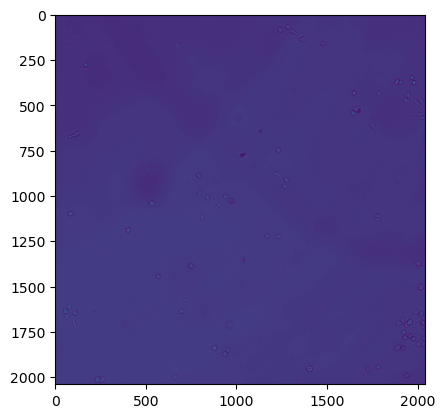

In [8]:
# read in image and show first frame
file='/home/pkh-lab-shared/migration_data_EK/11_6_23_LY294/timeSeries/D10_fld3.tif'
fr = 600 # s/fr # experiment
frames = tifffile.imread(file)

plt.imshow(frames[0])

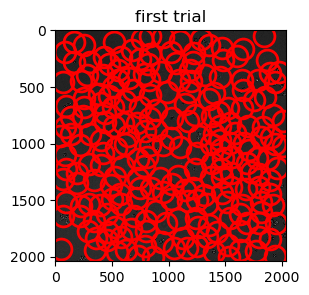

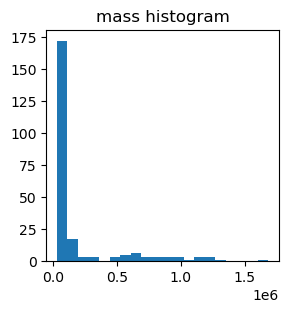

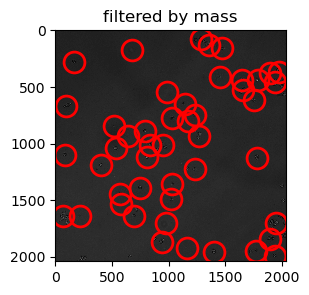

In [14]:
# determine parameters to track particles
# paramters: diameter, minmass
diameter=71
minmass=0.15e6
getParams(frames,refFrame=0,diameter=diameter,minmass=minmass)

Frame 72: 103 trajectories present.


/home/xfang2/anaconda3/lib/python3.9/site-packages/trackpy/motion.py:235: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
/home/xfang2/anaconda3/lib/python3.9/site-packages/trackpy/motion.py:236: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized


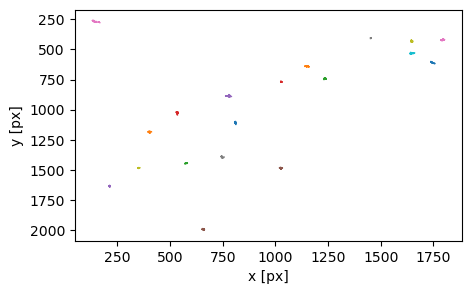

Double check, data contains ALL particle trajectories? (%d)


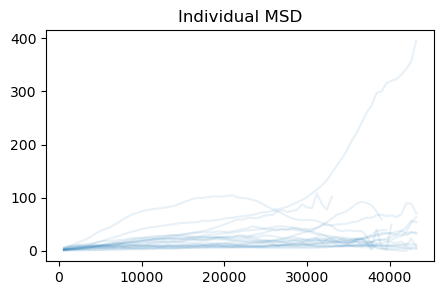

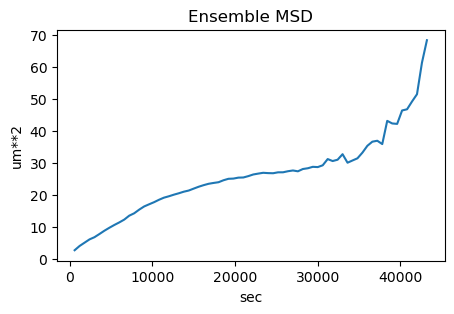

In [15]:
# run tracking
fb=DoTracking(frames,diameter=diameter,minmass=minmass)

# compute MSD
ts,traj,msd,im,em=DoMSD(fb,
    maxDist=10, # maximum displacement between frames in pixel
    maxMissFrame=3, # allowed number of frames a particle can disappear   
    minFrame=50, # minimum number of frames a trajectory needs to last
    pixelSize=0.65, # image pixel size in micron/pixel, specific for each scope and lens (Cytiva 10X: 0.65)
    frameRate=1/fr, # image acquisition rate in frames/sec
    max_lagtime=150, # intervals of frames out to which MSD is computed
     )

### No ATP 

Not sure how this naming scheme was decided upon 

In [8]:
# former path
path='/home/pkh-lab-shared/ekrueger2/microscopy_data/Confinement/confinement_data_11_14_22/'
# new path (rsync'd a local copy)
# rsync -ah /home/echo_nfs/microscopy_data/11_14_22_confinement/confinement_data_11_14_22 $KAFKA:/u1/pkekeneshuskey/delme/
#path='/u1/pkekeneshuskey/delme/confinement_data_11_14_22/'
#path="/u1/pkekeneshuskey/delme/confinement_data_12_12_22/xxxx/"

treatment=['11']
    
#density = ['A']
#fld = ['1','2','3'] 
#ATPno = ['1','2'] 


filenames_confinement = [] 
 
#for condition in treatment:
#    filenames_confinement.append(path+'Capture1-'+condition+'_XY0_Z0_T000_C0.tif')
filenames_confinement.append(path+'Capture1-Position6_noATP_unconfined_XY1670892965_Z0_T000_C0.tif')
#for dens in density: 
    #for f in fld: 
        #for ATP in ATPno: 
            #filenames_confinement.append(dens+ATP+'_fld'+f+'.tiff') 
#print(filenames_confinement)            

caseNames = ["-ATP" for x in range(len(filenames_confinement))]
#print(caseNames)

### With ATP 

In [9]:
# with atp? 
filenames_confinement_ATP=[]  

# they're from the experiments on 12/12/22. here is the pathway for that folder: 
# "/home/echo_nfs/microscopy_data/12_12_22_confinement/confinement_data_12_12_22/"
# rsync -ah /home/echo_nfs/microscopy_data/12_12_22_confinement/confinement_data_12_12_22 $KAFKA:/u1/pkekeneshuskey/delme/


# they're named based on being confined/unconfined and ATP/noATP
file="Capture1-Position12_ATP_unconfined_XY1670892971_Z0_T000_C0.tif"

filenames_confinement_ATP.append(path+file)
caseNamesATP = ["+ATP" for x in range(len(filenames_confinement_ATP))]
#print(casesATP)

filenames_confinement =  filenames_confinement + filenames_confinement_ATP
caseNames = caseNames + caseNamesATP


### Load images 

In [10]:
cases = dict()
class empty:pass

In [11]:

#filename =filenames_confinement[0]
#filename =filenames_confinement[1]
for i,filename in enumerate(filenames_confinement): 
#i=0
#filename = filenames_confinement[i]
#if 1:
    print("Processing ",filename)
    # NOT QUITE SURE WHY FRAMES IS USED HERE 
    frames = [] 
    frame = pims.open(filename) 
    frames.append(frame) 
    
    
    # load frame 
    v = np.array( frame ) 
    frame_i=v[:,:,:]
    print( np.shape(frame_i) )

    # display frame 
    plt.pcolormesh( np.flipud( frame_i[0,:,:] ), cmap='gray')


    # big steps 
    plt.figure()
    fb = DoTracking(frames)
    time1,t1, data = DoMSD(fb,caseNames[i]+".png")
    D,dataavg1 = DoFit(frames,time1,data)
    dists = CalcDistances(t1)
    DoSave(time1,dataavg1)
    
    # store data 
    case = empty()
    case.time1 = time1
    case.dataavg1 = dataavg1
    case.D = D 
    case.dists = dists
    case.frame = frame
    
    cases[caseNames[i]] = case 


Processing  /home/pkh-lab-shared/ekrueger2/microscopy_data/Confinement/confinement_data_11_14_22/Capture1-Position6_noATP_unconfined_XY1670892965_Z0_T000_C0.tif


/home/xfang2/anaconda3/lib/python3.9/site-packages/pims/api.py:204: UserWarning: <class 'pims.tiff_stack.TiffStack_tifffile'> errored: [Errno 2] No such file or directory: '/home/pkh-lab-shared/ekrueger2/microscopy_data/Confinement/confinement_data_11_14_22/Capture1-Position6_noATP_unconfined_XY1670892965_Z0_T000_C0.tif'
  warn(message)
/home/xfang2/anaconda3/lib/python3.9/site-packages/pims/api.py:204: UserWarning: <class 'pims.imageio_reader.ImageIOReader'> errored: No such file: '/home/pkh-lab-shared/ekrueger2/microscopy_data/Confinement/confinement_data_11_14_22/Capture1-Position6_noATP_unconfined_XY1670892965_Z0_T000_C0.tif'
  warn(message)
/home/xfang2/anaconda3/lib/python3.9/site-packages/pims/api.py:204: UserWarning: <class 'pims.bioformats.BioformatsReader'> errored: The file "/home/pkh-lab-shared/ekrueger2/microscopy_data/Confinement/confinement_data_11_14_22/Capture1-Position6_noATP_unconfined_XY1670892965_Z0_T000_C0.tif" does not exist.
  warn(message)


UnknownFormatError: All handlers returned exceptions:
<class 'pims.tiff_stack.TiffStack_tifffile'> errored: [Errno 2] No such file or directory: '/home/pkh-lab-shared/ekrueger2/microscopy_data/Confinement/confinement_data_11_14_22/Capture1-Position6_noATP_unconfined_XY1670892965_Z0_T000_C0.tif'
<class 'pims.imageio_reader.ImageIOReader'> errored: No such file: '/home/pkh-lab-shared/ekrueger2/microscopy_data/Confinement/confinement_data_11_14_22/Capture1-Position6_noATP_unconfined_XY1670892965_Z0_T000_C0.tif'
<class 'pims.bioformats.BioformatsReader'> errored: The file "/home/pkh-lab-shared/ekrueger2/microscopy_data/Confinement/confinement_data_11_14_22/Capture1-Position6_noATP_unconfined_XY1670892965_Z0_T000_C0.tif" does not exist.


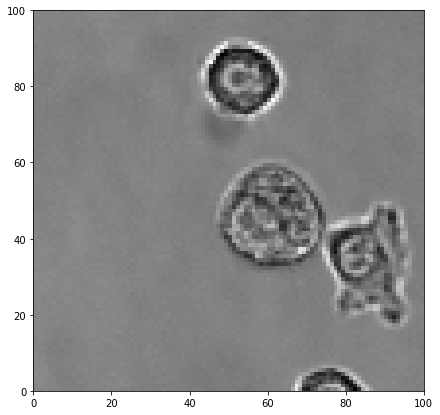

In [41]:
frame_i=v[0,100:200,350:450]

plt.pcolormesh(frame_i,cmap='gray')


Text(0, 0.5, 'Prob')

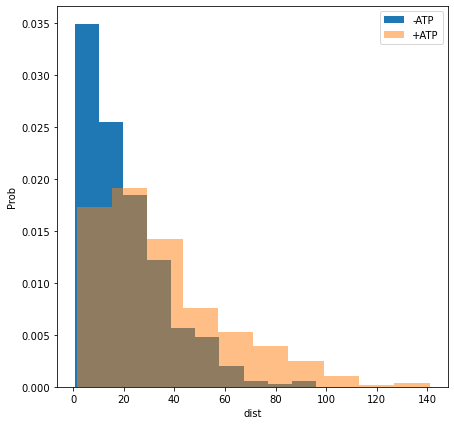

In [42]:
caseName='-ATP'
case = cases[caseName]
plt.hist(case.dists,density=True,label='-ATP')

caseName='+ATP'
case = cases[caseName]
plt.hist(case.dists,alpha=0.5,density=True,label='+ATP')
plt.legend(loc=0)
plt.xlabel("dist")
plt.ylabel("Prob")

* Tests
```
cd tests
```
* Run (kafka) 
```
python3 ../brownian_v3.py -yamlFile expt.yaml -run
```
* Process
```
python3 batchProcess.py -single expt # kant for now
```
* upload expt.csv



In [46]:
simFile = "expt.csv"
simData = np.loadtxt(simFile)

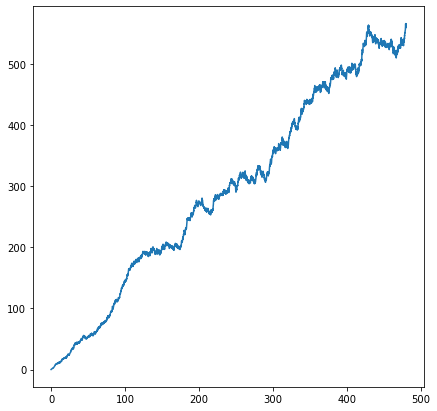

In [47]:
plt.plot(simData[:,0],simData[:,1])

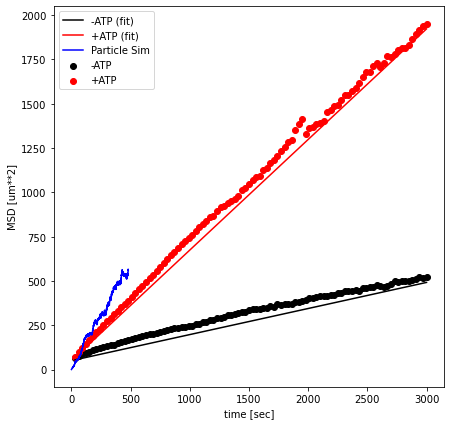

In [48]:
caseName = '-ATP'
case = cases[caseName]
plt.scatter(case.time1,case.dataavg1,facecolor='k',label=caseName)
msd = np.array(case.time1)*4*case.D + 50
plt.plot(case.time1, msd,'k',label=caseName+" (fit)")


caseName = '+ATP'
case = cases[caseName]
plt.scatter(case.time1,case.dataavg1,facecolor='r',label=caseName)
msd = np.array(case.time1)*4*case.D + 50
plt.plot(case.time1, msd,color='r',label=caseName+" (fit)")

plt.plot(simData[:,0],simData[:,1],color='b',label="Particle Sim")


plt.xlabel("time [sec]")
plt.ylabel("MSD [um**2]")
plt.legend(loc=0)
plt.gcf().savefig("msd.png",dpi=300)

In [49]:
msd[9]

206.09947014256585